In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import quad
from scipy.interpolate import interp1d
# from optical_depth.kappa import kappa

In [16]:
# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_SN2020tlf_data = np.log10(np.loadtxt('CSM_density/SN2020tlf.txt').T)
rho_SN2023ixf_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt').T)
rho_SN2023ixf_sharp_data = np.log10(np.loadtxt('CSM_density/SN2023ixf_sharp.txt').T)
rho_SN2024ggi_data = np.log10(np.loadtxt('CSM_density/SN2024ggi.txt').T)
# Interp in log10 scale
rho_2020tlf_interp = interp1d(rho_SN2020tlf_data[0],rho_SN2020tlf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_interp = interp1d(rho_SN2023ixf_data[0],rho_SN2023ixf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_s_interp = interp1d(rho_SN2023ixf_sharp_data[0],rho_SN2023ixf_sharp_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2024ggi_interp = interp1d(rho_SN2024ggi_data[0],rho_SN2024ggi_data[1],kind='linear',bounds_error=False,fill_value=np.nan)

# r_max = rho_data[0][-1]
# r_min = rho_data[0][0]

r_mins = {'SN 2020tlf':10**rho_SN2020tlf_data[0,0],'SN 2023ixf':10**rho_SN2023ixf_data[0,0],'SN 2023ixf s':10**rho_SN2023ixf_sharp_data[0,0],'SN 2024ggi':10**rho_SN2024ggi_data[0,0]} 

def CSM_density(r,SN_name='SN 2023ixf'):
    """
    g/cm^3
    """
    r = np.log10(r)
    if SN_name == 'SN 2020tlf':
        return 10**rho_2020tlf_interp(r)
    elif SN_name == 'SN 2023ixf':
        return 10**rho_2023ixf_interp(r)
    elif SN_name == 'SN 2023ixf s':
        return 10**rho_2023ixf_s_interp(r)
    elif SN_name == 'SN 2024ggi':
        return 10**rho_2024ggi_interp(r)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

SN_names = ['SN 2020tlf','SN 2023ixf','SN 2024ggi']

### Opacity $\kappa$ and optical depth $\tau$

To get the opacity $\kappa$ from OPAL table, define the relation
$$
\log_{10}R = \log_{10}\rho - 3\log_{10}T+18
$$
where $\rho$ and $T$ are the density and temperature of the medium in the units of ${\rm g~cm^{-3}}$ and ${\rm K}$.

With $\kappa$, the optical depth at layer $r$ can be evaluated by
$$
\tau(r) = -\int_\infty^r dr \rho(r) \kappa(r) = \int_r^{R_{\rm max}} dr \rho(r) \kappa(r)
$$
where $R_{\rm max}$ is the maximum radius of CSM. For SN 2023ixf, we set $R_{\rm max}\approx 9\times 10^{15}~{\rm cm}$. The maximum radius documented in Zimmerman+'s paper.

In [206]:
def get_logR(rho,T):
    return np.log10(rho) - 3 * np.log10(T) + 18

def tau(r,T,R_max=3e14,SN_name='SN 2023ixf'):
    def _rho_kappa(r):
        rho = CSM_density(r,SN_name)
        logR = get_logR(rho,T)
        if logR < -8.0:
            logR = -8.0
        logT = np.log10(T)
        return kappa(logR,logT) * rho
    return quad(_rho_kappa,r,R_max)[0]

In [168]:
get_logR(rho,T)

NameError: name 'rho' is not defined

In [178]:
get_logR(CSM_density(3e14),6e3)

-7.3484727023574195

In [292]:
log_rmin = np.log10(5e13)
log_rmax = np.log10(9e15)
CSM_radii = np.logspace(log_rmin,log_rmax,100)

In [294]:
tau_T6K = [tau(r,6e3,R_max=9e15,SN_name='SN 2023ixf s') for r in CSM_radii]
tau_T10K = [tau(r,1e4,R_max=9e15,SN_name='SN 2023ixf s') for r in CSM_radii]
tau_T25K = [tau(r,2.5e4,R_max=9e15,SN_name='SN 2023ixf s') for r in CSM_radii]
tau_T90K = [tau(r,9e4,R_max=9e15,SN_name='SN 2023ixf s') for r in CSM_radii]

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_38134/910590649.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(_rho_kappa,r,R_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_38134/910590649.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(_rho_kappa,r,R_max)[0]


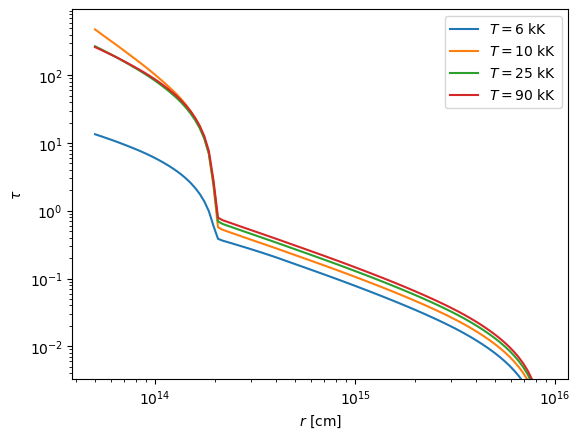

In [296]:
plt.plot(CSM_radii,tau_T6K,label=r'$T=6$ kK')
plt.plot(CSM_radii,tau_T10K,label=r'$T=10$ kK')
plt.plot(CSM_radii,tau_T25K,label=r'$T=25$ kK')
plt.plot(CSM_radii,tau_T90K,label=r'$T=90$ kK')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.0033,)
plt.legend()
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\tau$')
plt.savefig('tau_s.png',bbox_inches='tight')

In [308]:
tau_r = interp1d(np.log10(CSM_radii),np.log10(tau_T6K))

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_38134/1905414909.py:1: RuntimeWarning: invalid value encountered in log10
  tau_r = interp1d(np.log10(CSM_radii),np.log10(tau_T6K))


In [310]:
quad(lambda r: 10**tau_r(np.log10(r)),5e13,2e14)[0] / (2e14-5e13)

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_38134/3614202903.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(lambda r: 10**tau_r(np.log10(r)),5e13,2e14)[0] / (2e14-5e13)


4.886319937066155

In [314]:
1e14/3e10

3333.3333333333335

In [284]:
np.log10(25000)

4.3979400086720375